# Snapchat Political Ads
This project uses political ads data from Snapchat, a popular social media app. Interesting questions to consider include:
- What are the most prevalent organizations, advertisers, and ballot candidates in the data? Do you recognize any?
- What are the characteristics of ads with a large reach, i.e., many views? What may a campaign consider when maximizing an ad's reach?
- What are the characteristics of ads with a smaller reach, i.e., less views? Aside from funding constraints, why might a campaign want to produce an ad with a smaller but more targeted reach?
- What are the characteristics of the most expensive ads? If a campaign is limited on advertising funds, what type of ad may the campaign consider?
- What groups or regions are targeted frequently? (For example, for single-gender campaigns, are men or women targeted more frequently?) What groups or regions are targeted less frequently? Why? Does this depend on the type of campaign?
- Have the characteristics of ads changed over time (e.g. over the past year)?
- When is the most common local time of day for an ad's start date? What about the most common day of week? (Make sure to account for time zones for both questions.)

### Getting the Data
The data and its corresponding data dictionary is downloadable [here](https://www.snap.com/en-US/political-ads/). Download both the 2018 CSV and the 2019 CSV. 

The CSVs have the same filename; rename the CSVs as needed.

Note that the CSVs have the exact same columns and the exact same data dictionaries (`readme.txt`).

### Cleaning and EDA
- Concatenate the 2018 CSV and the 2019 CSV into one DataFrame so that we have data from both years.
- Clean the data.
    - Convert `StartDate` and `EndDate` into datetime. Make sure the datetimes are in the correct time zone.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

*Hint 1: What is the "Z" at the end of each timestamp?*

*Hint 2: `pd.to_datetime` will be useful here. `Series.dt.tz_convert` will be useful if a change in time zone is needed.*

*Tip: To visualize geospatial data, consider [Folium](https://python-visualization.github.io/folium/) or another geospatial plotting library.*

### Assessment of Missingness
Many columns which have `NaN` values may not actually have missing data. How come? In some cases, a null or empty value corresponds to an actual, meaningful value. For example, `readme.txt` states the following about `Gender`:

>  Gender - Gender targeting criteria used in the Ad. If empty, then it is targeting all genders

In this scenario, an empty `Gender` value (which is read in as `NaN` in pandas) corresponds to "all genders".

- Refer to the data dictionary to determine which columns do **not** belong to the scenario above. Assess the missingness of one of these columns.

### Hypothesis Test / Permutation Test
Find a hypothesis test or permutation test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
We chose the ads dataset from snapchat.
Questions we Investigate:
- Which organization spends the most on snapchat ads?
- Which organization serves the most different ads? 
- Which gender is more targeted? 
- Are ads served to by organizations to countries that they aren't based in? If so, what countries serve them? Which countries are they served to? Which country served the most of this type of ad?

### Cleaning and EDA
3. We added "DollarPerView" which is Spend/Impressions, "Year" which is the year that the ad was served in, and "Country" which is the country from the billing address of the organization serving the ad. We answered the question above about cross-serving, finding countries that cross-served, countries that were cross-served to & the names of the organizations that do this. Further, we imputed the Gender column with Both for Nans to reflect the implication of the Nan value

### Assessment of Missingness
4. For all of the missingness tests, we set a = .01 as the significance level. We looked at the segments column, which we think is not NMAR because segments end up targeting criteria used within the ad to determine other data. Using permutation tests, we found it is MAR dependent on: Spend, Impressions, CountryCode & EndDate. Each of these was as significant as can be: a pvalue of 0 for all. It is not MAR dependent with respect to LocationType from the given data.

### Hypothesis Test
5. Is it more expensive to get ad views in the US during election years? (I would expect that ads are pricier for election years) In this case, the null hypothesis is that these observations (ad spends) are drawn from the same distribution. The alternative, is that ads are more expensive in election years. We chose a = .01 as the significance level (so that only extremely significant results will conclude reject), KS as the test statistic (since difference of means was inconclusive). We got a p-value of 0 which implies we reject the null hypothesis. That is, political ad views on snapchat are more expensive in election years.

### Conclusion
6. If we had data on interactions with ads, we would be able to use this to get a more accurate idea than the DollarPerView gives us of what advertisers are paying for. Further, if we had more information on users (who saw what, whether they interacted & data about them) we would be able to do a more in-depth analysis of the ads. For example, if we knew how long people were on an ad, we would be able to determine whether users read the ad, whether they were idle when it came up or other such insights.

# Code

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pycountry 
import requests
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [3]:
import bs4

### Cleaning and EDA

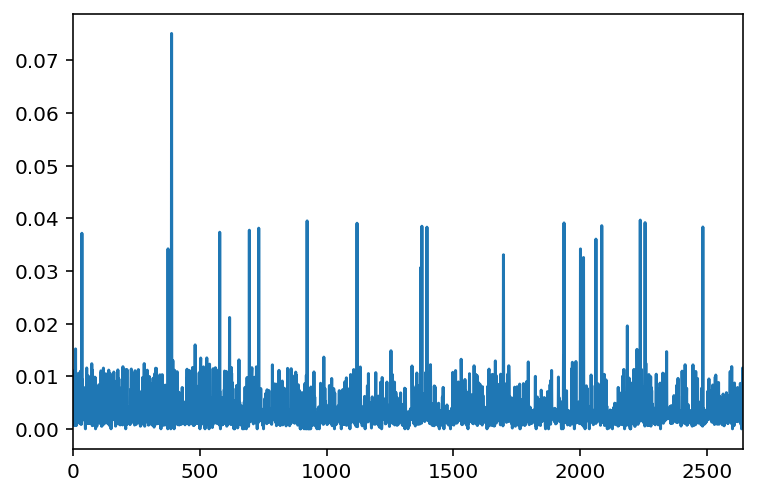

In [137]:
#read the files into dataframes
df_18 = pd.read_csv("PoliticalAds_18.csv")
df_19 = pd.read_csv("PoliticalAds_19.csv")
#adding a year column to both 18 and 19 dataframe that contains the year for every political ad
df_18 = df_18.assign(**{"Year": 18})
df_19 = df_19.assign(**{"Year": 19})
#concated the two years of information into one dataframe
catted_df = pd.concat([df_18, df_19])
#grabbed the countries from the mailing address and made a new column with this data
catted_df = catted_df.assign(**{"Country": catted_df['BillingAddress'].apply(lambda x: x[-2:])})
#converted the StartDate and EndDate to datetime objects in UTC time to be later used in our analysis
catted_df = catted_df.assign(**{"StartDate": pd.to_datetime(catted_df['StartDate'], infer_datetime_format = True)})
catted_df = catted_df.assign(**{"EndDate": pd.to_datetime(catted_df['EndDate'], infer_datetime_format = True)})
#found the dollar per view of all the ads
catted_df = catted_df.assign(**{"DollarPerView": catted_df['Spend'] / catted_df['Impressions']})
# impute gender column with 'BOTH' to symbolize that this ad targets both genders
catted_df['Gender_Filled'] = catted_df['Gender'].fillna('BOTH')
catted_df["DollarPerView"].plot();

It looks like part of this dataset is missing: some of the ads payed way more per view, this is probably because they had a higher click-through rate than the other ads. Generally, there is a small charge to show users an ad & a much higher charge if they interact with that ad. However, there is no data in the dataset that tells us why this may be.

In [129]:
num_ads_served_to = len(catted_df["CountryCode"].unique())
num_ads_served_by = len(catted_df["Country"].unique())
#bs4.BeautifulSoup(requests.get(df["CreativeUrl"][1]).text)#.prettify()
num_served_to_but_not_by = num_ads_served_to - num_ads_served_by
num_served_to_but_not_by
#This line gives the number of countries that were served to, but not by

7

That's interesting: at least 7 countries are getting political ads served by another country. Let's figure out which countries are getting ads, but not serving them. Also, let's figure out how many such ads there are

In [107]:
serving = catted_df["CountryCode"].unique()
catted_df = catted_df.assign(**{"Country": catted_df["Country"].apply(lambda x: pycountry.countries.get(alpha_2=x).name.lower())})
#This line turns the country code (ie US) to the lower case name of the associated country (ie united states)
ads_served_outside = catted_df["Country"] != catted_df["CountryCode"]
#This line compares the Country to the CountryCode, where Country is the Country of the mailing address 
#(where the ad is being served from) & the CountryCode is the where the ad is served to
ads_served_outside.sum()
#This line gives us the number of ads where the country of location targeted does not match the country of serving

105

This line gives all of the countries that were served ads by a group based in another country

In [125]:
catted_df.loc[ads_served_outside]["CountryCode"].unique()

array(['nigeria', 'iraq', 'united kingdom', 'australia', 'united states',
       'netherlands', 'kuwait', 'poland', 'germany', 'new zealand',
       'france', 'puerto rico', 'chile', 'sweden', 'norway', 'brazil',
       'austria'], dtype=object)

This line gives us the number of times that an ad was served by a country to another country, by country

In [139]:
outside_ad_counts = catted_df.loc[ads_served_outside][["Country","CountryCode"]].groupby("Country").count()
outside_ad_counts.head()

,CountryCode
Country,
AE,4
AU,5
BE,5
CA,10
FR,1


This line gives the country that served the most out of country political ads on snapchat, no surprise that it's the 
wealthiest country in the history of the world

In [119]:
outside_ad_counts.idxmax()

CountryCode    united states
dtype: object

This line gives the names of organizations that serve ads outside of the country in which they are based

In [121]:
catted_df.loc[ads_served_outside]["OrganizationName"].unique()

array(['Sponge Limited', 'LPM', 'Gorran Election Campaign', 'Fianna Fáil',
       'Tubemogul, Inc.', 'Stratos Developments Ltd.',
       'International Fund for Animal Welfare',
       'Middle Enterprises Pty Ltd', 'MMD Digital Solutions',
       'Avaaz Foundation', 'Ogilvy Group SA-NV', 'ItAllCounts Pty Ltd',
       'Ken Kinneen Limited', 'FTI Consulting LLP', 'MediaCom Canada',
       'Assembly', 'GLSEN', 'Timm & Pimm', 'Innsikt - Eniro Norge AS',
       'Open Mind Developments Corporation Inc.', 'YaaBuddy Ads',
       'Bates Pan Gulf', 'Socialyse (EUR)'], dtype=object)

From this, we were able to find the organization that had the most amount of money to spend on ads given by advertisers -> General Mills

In [141]:
catted_df.groupby('OrganizationName')['Spend'].sum().sort_values(ascending=False).head()

OrganizationName
General Mills                                  1092004
Cossette Media Inc                              509636
Assembly                                        444497
Mediavest Spark                                 223088
Australian Government Department of Finance     210000
Name: Spend, dtype: int64

From this, we were able to find the organization that created the most amount of snapchat ads -> UnRestrict Minnesota 

In [127]:
catted_df.groupby('OrganizationName')['ADID'].count().sort_values(ascending=False).head()

OrganizationName
UnRestrict Minnesota     297
Blueprint Interactive    235
The Aber Group           197
ACRONYM                  182
Chong and Koster         163
Name: ADID, dtype: int64

While the most amount of money was spent on ads that applied to both genders, more ad money was spent targeting females than males.

In [158]:
pd.DataFrame(catted_df.groupby('Gender_Filled')['Spend'].sum())

,Spend
Gender_Filled,
BOTH,4952290
FEMALE,165205
MALE,49271


### Assessment of Missingness
For the sake of ease, assume a significance level of a = .01

In [140]:
props = {}
#Iterate through columns
for col in catted_df.columns:
    #Find the total length of the column
    tot = len(catted_df[col])
    #Find the number of non-null values
    non_null = len(catted_df[col].dropna())
    #Calculate the proportion of non-nulls & put it in a dic for later use
    props[col] = (non_null / tot)
props
#This is the proportion of non-null values for each column

{'ADID': 1.0,
 'CreativeUrl': 1.0,
 'Spend': 1.0,
 'Impressions': 1.0,
 'StartDate': 1.0,
 'EndDate': 0.8013926733272783,
 'OrganizationName': 1.0,
 'BillingAddress': 1.0,
 'CandidateBallotInformation': 0.0681198910081744,
 'PayingAdvertiserName': 1.0,
 'Gender': 0.09748713290947623,
 'AgeBracket': 0.917045110505601,
 'CountryCode': 1.0,
 'RegionID': 0.3066908870723585,
 'ElectoralDistrictID': 0.019679079624583713,
 'LatLongRad': 0.0,
 'MetroID': 0.05449591280653951,
 'Interests': 0.23796548592188918,
 'OsType': 0.006357856494096276,
 'Segments': 0.66273085074175,
 'LocationType': 0.005449591280653951,
 'Language': 0.27671813502876175,
 'AdvancedDemographics': 0.029064486830154404,
 'Targeting Connection Type': 0.0,
 'Targeting Carrier (ISP)': 0.0,
 'Targeting Geo - Postal Code': 0.12079927338782924,
 'CreativeProperties': 0.8041174689676052,
 'Year': 1.0,
 'Country': 1.0,
 'DollarPerView': 1.0}

We want to see if Segments is MAR dependent on Spend

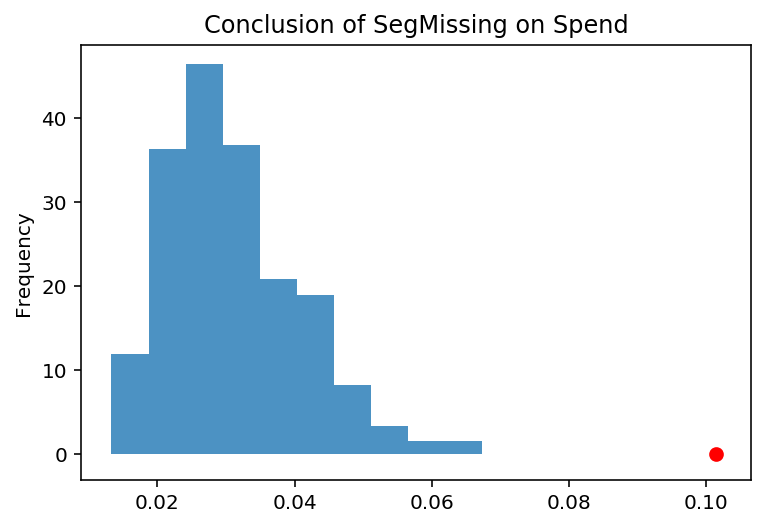

In [142]:
# This makes a column with booleans corresponding to the missingess of Segments, True if nan. I also select only 
#columns that will be used in the test, reducing the compuational load. This will be done for all subsequent tests
mdf = catted_df.assign(**{"SegMissing": catted_df["Segments"].isnull()})[["Spend", "SegMissing"]]
#Calculate the observed ks
obsks, _ = ks_2samp(
    mdf.loc[mdf['SegMissing'], 'Spend'],
    mdf.loc[~mdf['SegMissing'], 'Spend']
)
n_repetitions = 500
kslist = []
for _ in range(n_repetitions):
    
    # shuffle the Spend
    shuffled_spend = (
        mdf['Spend']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # Throw it into a df
    shuffled = (
        mdf
        .assign(**{'ShuffledSpend': shuffled_spend})
    )
    #compute test stat
    ks, _ = ks_2samp(
        shuffled.loc[shuffled['SegMissing'], 'ShuffledSpend'],
        shuffled.loc[~shuffled['SegMissing'], 'ShuffledSpend']
    )
    # add it to the list of results
    kslist.append(ks)
#Visualize the results
pd.Series(kslist).plot(kind='hist', density=True, alpha=0.8, title = "Conclusion of SegMissing on Spend")
plt.scatter(obsks, 0, color='red', s=40);

This permutation test tells us that segments are MAR dependent on Spend. Next, we will use the difference of means to determine whether Segments is MAR dependent on Impression

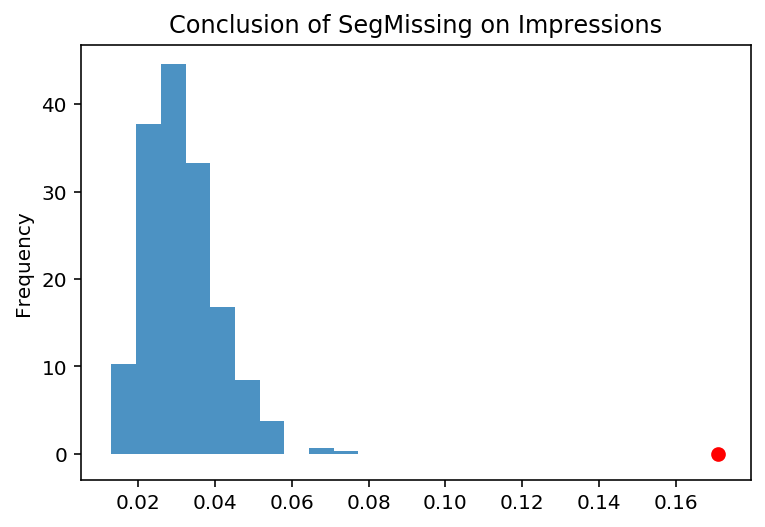

In [143]:
mdf = catted_df.assign(**{"SegMissing": catted_df["Segments"].isnull()})[["Impressions", "SegMissing"]]
#mdf.groupby("SegMissing").Spend.plot(kind = "kde", title = "Distribution of Spend by missingness of segs");
#Calculate the observed ks
obsks, _ = ks_2samp(
    mdf.loc[mdf['SegMissing'], 'Impressions'],
    mdf.loc[~mdf['SegMissing'], 'Impressions']
)
n_repetitions = 500
kslist = []
for _ in range(n_repetitions):
    
    # shuffle the Impressions
    shuffled_imp = (
        mdf['Impressions']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # Throw it into a df
    shuffled = (
        mdf
        .assign(**{'ShuffledImpressions': shuffled_imp})
    )
    #compute test stat
    ks, _ = ks_2samp(
        shuffled.loc[shuffled['SegMissing'], 'ShuffledImpressions'],
        shuffled.loc[~shuffled['SegMissing'], 'ShuffledImpressions']
    )
    # add it to the list of results
    kslist.append(ks)
#Visualize the results
pd.Series(kslist).plot(kind='hist', density=True, alpha=0.8, title = "Conclusion of SegMissing on Impressions")
plt.scatter(obsks, 0, color='red', s=40);

This tells us that segments are MAR dependent on Impressions

Is the Segments MAR dependent on Country?


In [59]:
df = catted_df.assign(**{"SegMissing": catted_df["Segments"].isnull()})[["SegMissing", "CountryCode"]]

In [56]:
n_repetitions = 500

tvds = []
for _ in range(n_repetitions):
    
    # shuffle the CountryCode column
    shuffled_col = (
        df['CountryCode']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        df
        .assign(**{
            'CountryCode': shuffled_col
        })
    )
    
    # compute the tvd
    shuffled = (
        shuffled
        .pivot_table(index='SegMissing', columns='CountryCode', aggfunc='size')
        .apply(lambda x:x / x.sum(), axis=1)
    )
    
    tvd = shuffled.diff().iloc[-1].abs().sum() / 2
    # add it to the list of results
    
    tvds.append(tvd)

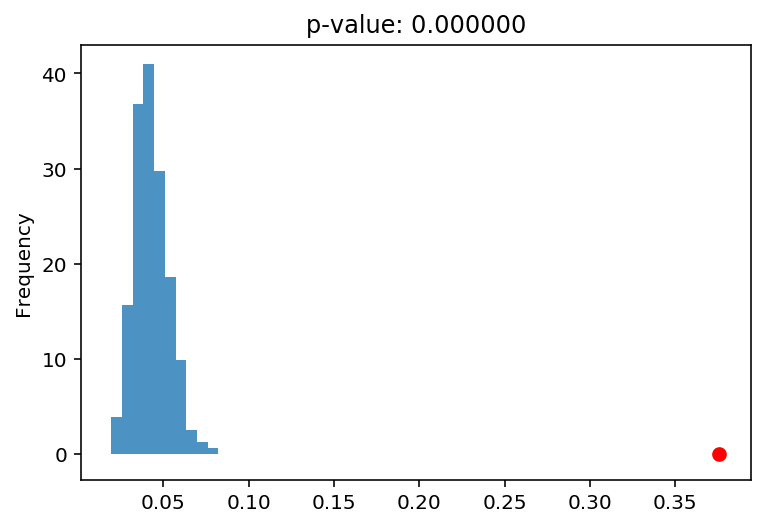

In [58]:
distr = (
    df
    .pivot_table(index='SegMissing', columns='CountryCode', aggfunc='size')
    .apply(lambda x:x / x.sum(), axis=1)
)
obs = distr.diff().iloc[-1].abs().sum() / 2
#Calculate the observed test stat
pval = np.mean(tvds > obs)
#Calculate pval & plot the result of the hypothesis test
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)
plt.scatter(obs, 0, color='red', s=40);

This test concludes that Segments is MAR dependent on CountryCode. Are the Segments MAR dependent on EndDate?

In [62]:
df = catted_df.assign(**{"SegMissing": catted_df["Segments"].isnull()})[["SegMissing", "EndDate"]]

In [63]:
n_repetitions = 500
tvds = []
for _ in range(n_repetitions):
    
    # shuffle the EndDate column
    shuffled_col = (
        df['EndDate']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        df
        .assign(**{
            'EndDate': shuffled_col
        })
    )
    
    # compute the tvd
    shuffled = (
        shuffled
        .pivot_table(index='SegMissing', columns='EndDate', aggfunc='size')
        .apply(lambda x:x / x.sum(), axis=1)
    )
    
    tvd = shuffled.diff().iloc[-1].abs().sum() / 2
    # add it to the list of results
    
    tvds.append(tvd)

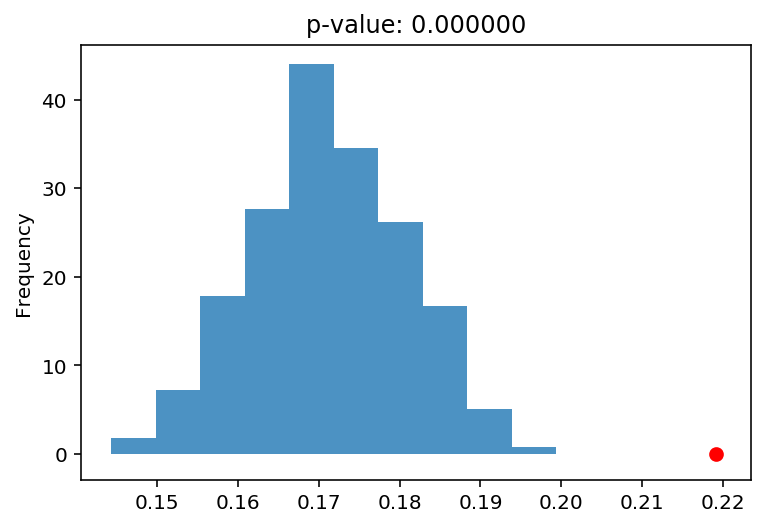

In [66]:
distr = (
    df
    .pivot_table(index='SegMissing', columns='EndDate', aggfunc='size')
    .apply(lambda x:x / x.sum(), axis=1)
)
obs = distr.diff().iloc[-1].abs().sum() / 2
#Calculate the observed test stat
pval = np.mean(tvds > obs)
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)
plt.scatter(obs, 0, color='red', s=40);

This test tells us that Segments are MAR dependent on EndDate. I will now try it on LocationType

In [68]:
df = catted_df.assign(**{"SegMissing": catted_df["Segments"].isnull()})[["SegMissing", "LocationType"]]

In [69]:
n_repetitions = 500
tvds = []
for _ in range(n_repetitions):
    
    # shuffle the LocationType column
    shuffled_col = (
        df['LocationType']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        df
        .assign(**{
            'LocationType': shuffled_col
        })
    )
    
    # compute the tvd
    shuffled = (
        shuffled
        .pivot_table(index='SegMissing', columns='LocationType', aggfunc='size')
        .apply(lambda x:x / x.sum(), axis=1)
    )
    
    tvd = shuffled.diff().iloc[-1].abs().sum() / 2
    # add it to the list of results
    
    tvds.append(tvd)

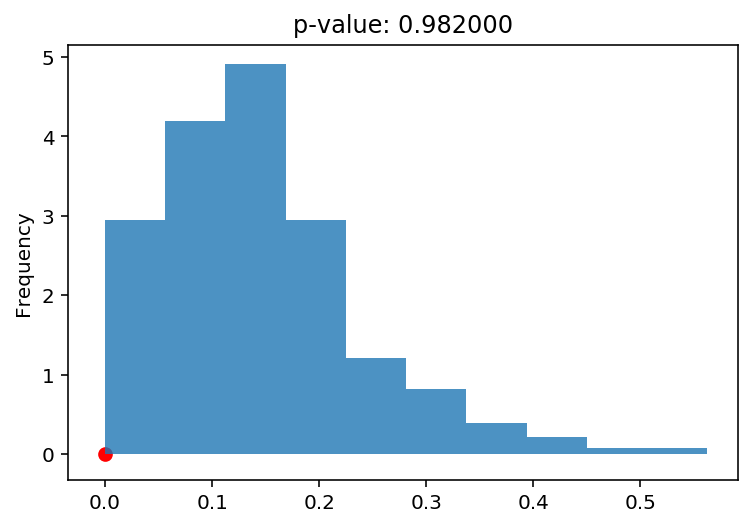

In [70]:
distr = (
    df
    .pivot_table(index='SegMissing', columns='LocationType', aggfunc='size')
    .apply(lambda x:x / x.sum(), axis=1)
)
obs = distr.diff().iloc[-1].abs().sum() / 2
#Calculate the observed test stat
pval = np.mean(tvds > obs)
#Calculate the pvalue & plot the results of the hypothesis test
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)
plt.scatter(obs, 0, color='red', s=40);

This tells us that Segments are not dependent on LocationType. (Please note that LocationType is only non-null in ~ .5% of cases, so this is not a very significant result)

### Hypothesis Test
For the sake of ease, assume a significance level of a = .01

For our hypothesis test, we are looking within the US across years to determine whether or not the cost of spending per view varies between midterm election years versus nonelection years. In this case, the null hypothesis is that these observations (ad spends) are drawn from the same distribution. The alternative, that they are not.

In [48]:
us_df = catted_df.query("Country == 'US'")
us_df = us_df.assign(**{"ElectionYear":us_df["Year"].apply(lambda x: True if x == 18 else False)})

In [46]:
trials = 1000
#Permutation test using absolute difference of means
outliers = 0
#limit the numbers to ones within the US
obs = us_df.groupby("Year")["DollarPerView"].mean().diff().abs()[19]
# Calculate observed difference of means
us_df = us_df[["DollarPerView", "Year"]]
doms = []
for _ in range(trials):
    #shuffle relevant values
    shuffled = us_df.sample(frac=1,replace=False).reset_index(drop=True)["DollarPerView"]
    #assign the shuffleds to a df
    samp = us_df.assign(**{"DollarPerView":shuffled})
    test_stat = samp.groupby("Year")["DollarPerView"].mean().diff().abs()[19]
    #This calculates the abs diff of means of the sample
    doms.append(test_stat)
    #Making a list of mean diffs, for plotting
    if test_stat <= obs:
        #Count outliers to calc pval
        outliers += 1
outliers/trials

0.776

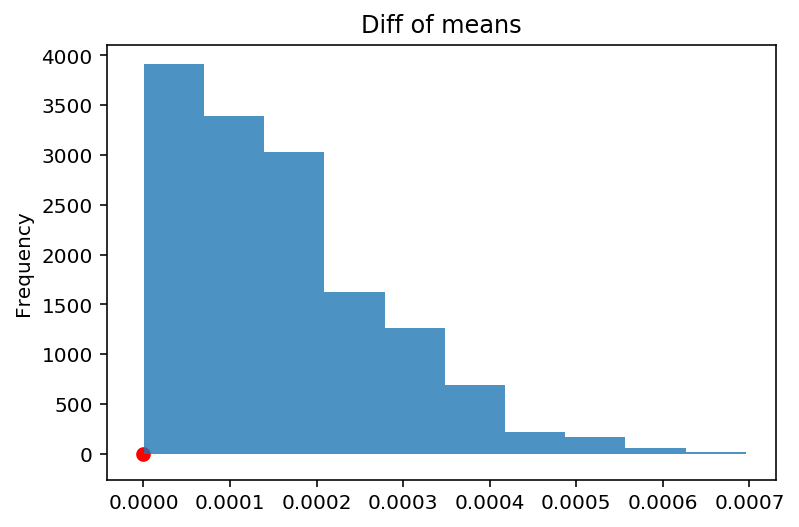

In [152]:
pd.Series(doms).plot(kind='hist', density=True, alpha=0.8)
#Visualizing the results of diff of means permutation test
plt.scatter(obs, 0, color='red', s=40);#.set_title("Diff of means");
plt.title("Diff of means");

So difference of means does not give me a statistically significant result, 
let's see if this was because the test stat fails to pick up the difference, 
or they really are drawn from the same distribution

In [157]:
from scipy.stats import ks_2samp
ks = []
oks, _ = ks_2samp(us_df.loc[us_df["ElectionYear"], "DollarPerView"], us_df.loc[~us_df["ElectionYear"], "DollarPerView"])
# Permutation test using the ks_stat
for _ in range(trials):
    #shuffle relevant values
    shuffled = us_df.sample(frac=1,replace=False).reset_index(drop=True)["DollarPerView"]
    #put the shuffleds into a df
    samp = us_df.assign(**{"DollarPerView":shuffled})
    #compute the test statistic
    tks, _ = ks_2samp(samp.loc[samp["ElectionYear"], "DollarPerView"],samp.loc[~samp["ElectionYear"], "DollarPerView"])
    #add it to a list of test_stats for plotting
    ks.append(tks)
np.count_nonzero(np.array(ks) <= oks) / len(ks)
#This gives the pval of this test

0.0

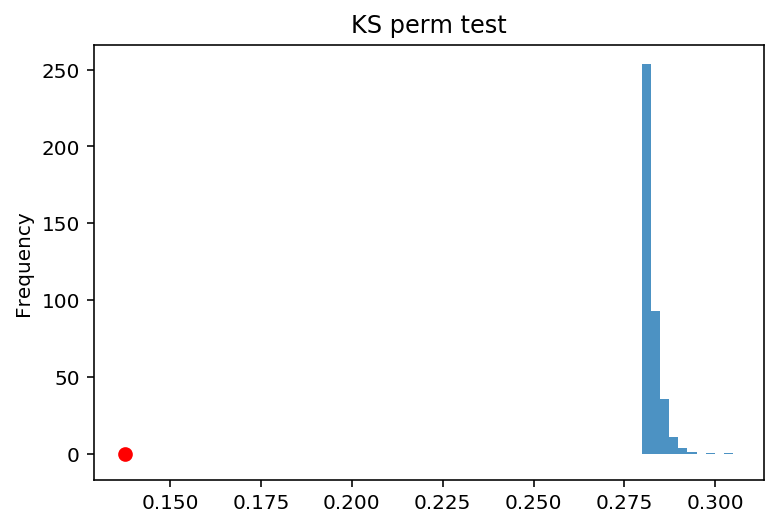

In [156]:
pd.Series(ks).plot(kind='hist', density=True, alpha=0.8)
# Visualize the result of ks permutation test
plt.scatter(oks, 0, color='red', s=40);
plt.title("KS perm test");

Using the ks-statistic, we see that these are not drawn from the same distribution. That is, DollarPerView is higher in election years than non-election years